In [2]:
from IPython.display import display, Math, Latex
# This is imported for proper rendering of Latex in Notebook.

In [3]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

np.random.seed(306)
plt.style.use('seaborn')

# Least Square Classifier (LSC)

# Background

We will implement the least square classification from scratch in this notebook.

A few pointers:
- Least square classification is used for estimating parameters of discriminant functions from the given training data.
- Least square classification adapts linear regression model for classification.
    - It uses **least square error** as a **loss function**.
    - It uses **normal equation** method and **gradient descent** for estimating model parameters or weight vector.
- Since it is a classifcation algorithm, we should we classification related evaluation metrics such as precision, recall, F-1 score, AUC ROC/PR and accuracy.

Additionally note that:
- We can make use of polynomial feature transformation to obtain new features and use that representation to learn non-linear decision boundaries between classes using the following equation:
$$y = w_0 + w^T \phi(x)$$
where, $\phi(x)$ is a polynomial feature transformation.
- We can tackle issures of overfitting by using ridge or lasso regularization, just like as in linear regression model.

# Implementation

## `polynomial_transform`

We define a helper function to transform the feature matrices into their polynomial combination, given the degree.

In [8]:
import itertools,functools

def get_combinations(x, degree):
    '''
    Return successive r-length combinations of elements in the iterable allowing individual elements to have successive repeats.

    combinations_with_replacement('ABC', 2) --> AA AB AC BB BC CC"
    '''
    return itertools.combinations_with_replacement(x,degree)

def compute_new_feature(items):
    '''
    reduce(function, sequence[, initial]) -> value

    Apply a function of two arguments cumulatively to the items of a sequence, from left to right, so as to reduce the sequence to a single value.

    For example: 
    reduce(lambda x, y: x+y, [1, 2, 3, 4, 5]) calculates ((((1+2)+3)+4)+5). 
    
    If initial is present, it is placed before the items of the sequence in the calculation, and serves as a default when the sequence is empty.

    reduce(lambda x,y: x*y, [1, 2, 3, 4, 5]) calculates ((((1*2)*3)*4)*5).
    '''
    return functools.reduce(lambda x, y: x*y, items)

def polynomial_transform(x, degree, logging=False):
    '''
    Steps for generating polynomial transformations of degree M ---
        
        1. Generate combination of input features of lengths = {0,1,...,M}.
        
        2. Perform multiplication operation between features to obtain the required new features.
    
    logging: Bool - True to print all the combinations and their products.
    '''
    
    # If 'x' is 1-dim, it is first converted to a feature matrix.
    # [1,2,3,4] to [[1],[2],[3],[4]]
    if x.ndim == 1:
        x = x[:,None]
    
    # Transpose of feature matrix
    x_t = x.transpose()

    # Populates 1's as first feature for each example, the degree 0 feature.
    features  = [np.ones(len(x))]

    if logging:
        print("Input: ",x)
    
    # for each degree d
    for d in range(1, degree+1):
        # generate combinations of degree d
        for x in get_combinations(x_t, d):
            # take product of no.s in x, and combine them into a single feature
            features.append(compute_new_feature(x))
            if logging:
                print(x,compute_new_feature(x), sep = ': ')
    
    if logging:
        print("Output: ", np.asarray(features).transpose())
    
    return np.asarray(features).transpose()

## Label Encoding

Since, the output $y$ is a discrete quantity, we use one-hot encoding to represent label. For a **binary classification**:
- The label `0` is represented with `[1, 0]`, and
- The label `1` is represented wiht `[0, 1]`.

The same scheme is extended to **multi-class setting**. In general for a $k$ class set up, we use one hot encoding via  $k$ component vector. $[y_1, y_2, y_3, \dots, y_k]$. For label $1 \le r \le k$, $y_r$ would be `1` and other components would be `0`.

Concretely, for a three class classification set up,
- The label `0` is represented by `[1, 0, 0]`
- The label `1` is represented by `[0, 1, 0]`
- The label `2` is represented by `[0, 0, 1]`.

In the following notebook, we implement the class `LabelTransformer` that converts discrete label into a one hot encoding.

In [5]:
class LabelTransformer(object):
    '''
    Label encoder decoder
    Attributes
    ----------
    n_classes : int
        number of classes, K
    '''

    def __init__(self, n_classes:int=None):
        self.n_classes = n_classes
    
    @property
    def n_classes(self):
        return self.__n_classes
    
    @n_classes.setter
    def n_classes(self, K):
        self.__n_classes = K
        self.__encoder = None if K is None else np.eye(K)
    
    @property
    def encoder(self):
        return self.__encoder
    
    def encode(self, class_indices:np.ndarray):
        '''
        encode class index into one-of-k code
        Parameters
        ----------
        class_indices : (N,) np.ndarray
            non-negative class index
            elements must be integer in [0, n_classes)
        Returns
        -------
        (N, K) np.ndarray
            one-of-k encoding of input
        '''
        if self.n_classes is None:
            self.n_classes = np.max(class_indices) + 1
        
        return self.encoder[class_indices]
    
    def decode(self, onehot:np.ndarray):
        '''
        decode one-of-k code into class index
        Parameters
        ----------
        onehot : (N,K) np.ndarray
            one-of-k code
        Returns
        -------
        (N,) np.ndarray
            class index
        '''
        return np.argmax(onehot, axis=1)

Let's demonstrate the `LabelTransformer`:

Binary classification set up:

In [9]:
binary_labels = LabelTransformer(2).encode(np.array([1, 0, 1, 0]))
binary_labels

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.]])

Multiclass set up with three classes:

In [10]:
multiclass_labels = LabelTransformer(3).encode(np.array([1, 0, 1, 2]))
multiclass_labels

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

## Least Square Classification (LSC) implementation

### Training Data

This representation of label has an impact on the learning set up. Now we have
- A feature matrix $X$ of shape $(n,m)$, where $n$ is the no. of examples, $m$ is the no. of features.
- A label matrix $Y$ of shape $(n,k)$, where $k$ is the no. of class labels. Note that this setup is similar to **multi label regression**.

### Model

The label matrix is obtained by matrix multiplication of feature matrix and weight matrix. After adding a dummy feature to the feature matrix, its shape becomes $(n,(m+1))$. It follows the following equation:
$$Y_{n \times k} = X_{n \times (m+1)} W_{(m+1) \times k}$$
- There is one weight vector per output. Hence the total no. of parameters to be estimated = $(m+1) \times k$.

### Loss Function

This results into the following loss matrix of shape $(k,k)$.
$$J(W) = \frac{1}{2} (Y_{n \times k} - X_{n \times (m+1)} W_{(m+1) \times k})^T (Y_{n \times k} - X_{n \times (m+1)} W_{(m+1) \times k}) + \frac{\lambda}{2} W^T W $$

$$= \frac{1}{2} (E^T E)_{k \times k} + \frac{\lambda}{2} (W^T W)_{k \times k}$$

### Normal Equation

There is almost no code change needed in fit function that uses normal equation method for parameter or weight vector estimation:
$$W = (X^T X + \lambda I)^{-1} X^T Y$$

### Iterative Optimization (GD, MBGD and SGD)

The gradient calculation (`calculate_gradient`) for iterative optimization is performed as follows:
$$\frac{\partial J(W)}{\partial W} = X^T (X W - Y) + \lambda W$$

And the new value of $W$ is calculated in vectorized form as:
$$W^{\text{new}} := W^{\text{old}} - \alpha \frac{\partial J(W)}{\partial W}$$

### Inference

The `predict` function for this classification set up is espected to return a discrete quantity (unlike a real number in regression set up)
- We return the class label with largest value of linear combination of features amongst all the classes.

### Multi-class classification
This implementation is generic enough to work on multi-class set up and also polynomial transformation followed by least squares classification.

In [11]:
class LeastSquareClassification(object):
    '''
    LSC Model
    ---------
    y = np.where(X@w >= 0, 1, 0)
    X: A feature matrix
    w: weight vector
    y: label vector
    '''

    def __init__(self):
        self.t0 = 20
        self.t1 = 1000
    
    def predict(self, X:np.ndarray) -> np.ndarray:
        '''Prediction of output label for a given input.

        Args:
            X: Feature matrix for given inputs
        
        Returns:
            y: Output label vector as predicted by the given model
        '''
        # Check to make sure the shapes are compatible
        assert X.shape[-1]==self.w.shape[0], f"X shape {X.shape} and w shape {self.w.shape}, are not compatible"

        return np.argmax(X@self.w, axis=1)
    
    def predict_internal(self, X:np.ndarray) -> np.ndarray:
        '''Prediction of output label for a given input.

        Args:
            X: Feature matrix for given inputs
        
        Returns:
            y: Output label matrix encoded in label encoder format
        '''
        # Check to make sure the shapes are compatible
        assert X.shape[-1]==self.w.shape[0], f"X shape {X.shape} and w shape {self.w.shape}, are not compatible"

        return X@self.w

    def loss(self, X:np.ndarray, y:np.ndarray, reg_rate:float=0) -> float:
        '''Calculate loss for a model based on actual labels.

        Args:
            X: Feature matrix for given inputs
            y: Output label vector as known from the dataset (one-hot form)
            reg_rate: Rate of regularization
        
        Returns:
            Loss
        '''

        e = y - self.predict_internal(X)
        # Here y is in the one-hot encoded form
        return (1/2) * (np.transpose(e) @ e) + (reg_rate/2) * (np.transpose(self.w) @ self.w)

    # Normal Equation based estimation
    def fit(self, X:np.ndarray, y:np.ndarray, reg_rate:float=0) -> np.ndarray:
        '''Estimate parameters of linear regression model with normal equation.

        Args:
            X: Feature matrix for given inputs
            y: Output label vector as known from the dataset (one-hot form)
            reg_rate: Rate of regularization
        
        Returns:
            Weight vector via normal equation
        '''
        # self.w = np.linalg.pinv(X) @ y

        self.w = np.zeros((X.shape[1],y.shape[1]))
        eye = np.eye(np.size(X,1))
        self.w = np.linalg.solve(
            reg_rate * eye + X.T @ X,
            X.T @ y,
        )

        return self.w

    def calculate_gradient(self, X:np.ndarray, y:np.ndarray, reg_rate:float=0) -> np.ndarray:
        '''Calculate gradients of loss function w.r.t. weight vector on training set.

        Args:
            X: Feature matrix for given inputs
            y: Output label vector as known from the dataset (one-hot form)
            reg_rate: Rate of regularization
        
        Returns:
            A vector of gradients
        '''
        return np.transpose(X) @ (self.predict_internal(X) - y) + reg_rate * self.w
    
    def update_weights(self, grad:np.ndarray, lr:float) -> np.ndarray:
        '''Update the weights based on the gradient of the loss function.

        Weight updates are carried out with the following formula:
            w_new := w_old - lr * grad
        
        Args:
            grad: Gradient of loss w.r.t w
            lr: Learning rate
        
        Returns:
            Updated weight vector
        '''
        return self.w - lr * grad
    
    # Dynamic learning rate
    def learning_schedule(self, t):
        return self.t0/(t + self.t1)
    
    # GD - Gradient Descent
    def gd(self, X:np.ndarray, y:np.ndarray, num_epochs:int, lr:float, reg_rate:float=0) -> np.ndarray:
        '''Estimates parameters of linear regression model through gradient descent.
        
        Args:
            X: Feature matrix for training data
            y: Output label (in one-hot form) for training
            num_epochs: Number of training steps
            lr: Learning rate
            reg_rate: Rate of regularization
        
        Returns:
            Weight vector: Final weight vector
        '''
        self.w = np.zeros((X.shape[1],y.shape[1]))
        self.w_all = []
        self.err_all = []
        
        for i in np.arange(0, num_epochs):
            dJdW = self.calculate_gradient(X,y,reg_rate)
            self.w_all.append(self.w)
            self.err_all.append(self.loss(X,y,reg_rate))
            self.w = self.update_weights(dJdW, lr)
        
        return self.w
    
    # MBGD - Mini-Batch Gradient Descent
    def mbgd(self, X:np.ndarray, y:np.ndarray, num_epochs:int, batch_size:int, reg_rate:float=0) -> np.ndarray:
        '''Estimates parameters of linear regression model through mini-batch gradient descent.
        
        Args:
            X: Feature matrix for training data
            y: Output label (in one-hot form) for training
            num_epochs: No. of epochs (no. of times MBGD is done over the whole training set)
            batch_size: Size of each mini-batch, after which we update the weights
            reg_rate: Rate of regularization
        
        Returns:
            Weight vector: Final weight vector
        '''
        self.w = np.zeros((X.shape[1],y.shape[1]))
        self.w_all = []
        self.err_all = []
        mini_batch_id = 0

        for epoch in range(num_epochs):
            shuffled_indices = np.random.permutation(X.shape[0])
            X_shuffled = X[shuffled_indices]
            y_shuffled = y[shuffled_indices]

            for i in range(0, X.shape[0], batch_size):
                mini_batch_id += 1
                
                # ith mini-batch
                Xi = X_shuffled[i:i + batch_size]
                yi = y_shuffled[i:i + batch_size]

                lr = self.learning_schedule(mini_batch_id)
                gradients = (2/ batch_size) * self.calculate_gradient(Xi, yi, reg_rate)

                self.w_all.append(self.w)
                self.err_all.append(self.loss(Xi, yi, reg_rate))
                self.w = self.update_weights(gradients, lr)
        
        return self.w
    
    # SGD - Stochastic Gradient Descent
    def sgd(self, X:np.ndarray, y:np.ndarray, num_epochs:int, reg_rate:float=0) -> np.ndarray:
        '''Estimates parameters of linear regression model through stochastic gradient descent.
        
        Args:
            X: Feature matrix for training data
            y: Output label for training data vector
            num_epochs: No. of epochs (no. of times MBGD is done over the whole training set)
            reg_rate: Rate of regularization
        
        Returns:
            Weight vector: Final weight vector
        '''
        self.w = np.zeros((X.shape[1],y.shape[1]))
        self.w_all = []
        self.err_all = []

        for epoch in range(num_epochs):
            for i in range(X.shape[0]):
                random_index = np.random.randint(X.shape[0])
                Xi = X[random_index:random_index+1]
                yi = y[random_index:random_index+1]

                lr = self.learning_schedule(epoch * X.shape[0] + i)
                gradients = 2 * self.calculate_gradient(Xi, yi, reg_rate)

                self.w_all.append(self.w)
                self.err_all.append(self.loss(Xi,yi,reg_rate))
                self.w = self.update_weights(gradients, lr)
        
        return self.w


## Demonstration of LSC

We will demonstrate working on least square classification in the following set ups:
1. Linearly separable binary classification set up.
2. Linearly separable binary classification set up with a few outliers.
3. Multi-class classification with $k = 3$.
4. Polynomial LSC.

Let's create a dataset for binary classification with no. of samples, $n = 50$.
- It also has facility to add outliers to the generated dataset.
- And it can generate samples from multiple classes (`> 2`).

In [14]:
##@title Toy dataset creation
def create_toy_data(add_outliers=False, add_class=False):
    '''
    Here we are generating 50 examples with 2 features each.
    
    If add_outliers=True, we add 5 more outlier examples.
    
    If add_class=True, we add 25 exaamples more of the third class type, making the total no. of samples to 75.
    '''
    x0 = np.random.normal(size=50).reshape(-1,2) - 1
    x1 = np.random.normal(size=50).reshape(-1,2) + 1
    if add_outliers:
        x_1 = np.random.normal(size=10).reshape(-1,2) + np.array([5., 10.])
        return np.concatenate([x0, x1, x_1]), np.concatenate([np.zeros(25), np.ones(30)]).astype(np.int)
    if add_class:
        x2 = np.random.normal(size=50).reshape(-1,2) + 2
        return np.concatenate([x0, x1, x2]), np.concatenate([np.zeros(25), np.ones(25), 2 + np.zeros(25)]).astype(np.int)
    return np.concatenate([x0, x1]), np.concatenate([np.zeros(25), np.ones(25)]).astype(np.int)

First let's define a generic data preprocessing function that does the following:
1. Generates synthetic data by calling `create_toy_data` function.
2. Perform polynomial transformation (default `degree=1`) on the feature set.
3. Divides the data into training and evaluation sets with `train_test_split` API from `sklearn` library.
4. Perform label transformation for train and test sets.

In [22]:
##@title Data preprocessing
from sklearn.model_selection import train_test_split

def preprocess(add_outliers=False, add_class=False, degree=1):
    '''
    This creates and preprocesses synthetic data using `create_toy_data`
    '''
    x,y = create_toy_data(add_outliers, add_class)
    x_poly = polynomial_transform(x, degree=degree)
    x_train, x_test, y_train, y_test = train_test_split(x_poly, y)
    y_train_trans = LabelTransformer().encode(y_train)
    y_test_trans = LabelTransformer().encode(y_test)

    return x_train, x_test, y_train, y_test, y_train_trans, y_test_trans

In [34]:
#@title Model Visualization
def visualize_model(X_train, labels, lsc_obj, degree=1):

    f = plt.figure(figsize=(6,6))

    # compute xlim, ylim
    # First feature already has the dummy variable attached (because of polnomial transform)
    # min,max of feature 1
    x1_min = np.min(X_train[:,1])
    x1_max = np.max(X_train[:,1])
    # min,max of feature 2
    x2_min = np.min(X_train[:,2])
    x2_max = np.max(X_train[:,2])

    x1_test, x2_test = np.meshgrid(np.linspace(x1_min,x1_max, 100), np.linspace(x2_min,x2_max, 100))
    x_test = np.array([x1_test, x2_test]).reshape(2,-1).T
    x_test_poly = polynomial_transform(x_test, degree=degree)
    y_test_pred = lsc_obj.predict(x_test_poly)

    sns.scatterplot(data=X_train, x=X_train[:,1], y=X_train[:,2], hue=labels)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.xlim(x1_min,x1_max)
    plt.ylim(x2_min,x2_max)
    
    plt.contourf(x1_test, x2_test, y_test_pred.reshape(100,100), alpha=0.5, levels=np.linspace(0,1,3))

    plt.show()

In [41]:
# This is what `np.meshgrid` does
nx, ny = (3, 2)
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
xv, yv = np.meshgrid(x, y)
print(x,y)
print(xv,yv, sep = '\n')

[0.  0.5 1. ] [0. 1.]
[[0.  0.5 1. ]
 [0.  0.5 1. ]]
[[0. 0. 0.]
 [1. 1. 1.]]


## Demo 1: Linearly separable Binary Classification

In [23]:
x_train, x_test, y_train, y_test, y_train_trans, y_test_trans = preprocess()

Let's examine the datasets.

In [24]:
print("Shape of training feature matrix", x_train.shape)
print("Shape of training label vector", y_train.shape)

print("Shape of test feature matrix", x_test.shape)
print("Shape of test label vector", y_test.shape)

Shape of training feature matrix (37, 3)
Shape of training label vector (37,)
Shape of test feature matrix (13, 3)
Shape of test label vector (13,)


Note that the **first dimension of feature matrix and label vecto matches** in training and test sets, which is how it should be!

Let's visualize the created data

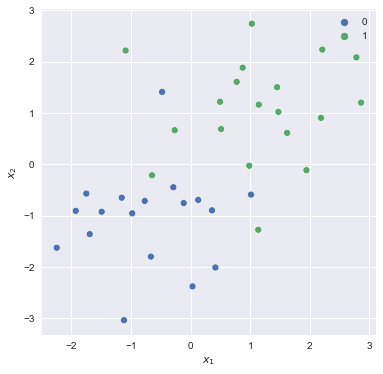

In [26]:
plt.figure(figsize=(6,6))
sns.scatterplot(data=x_train, x= x_train[:,-2], y = x_train[:,-1], hue=y_train)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

Now, we begin building the LSC classifier.

In [27]:
lsc = LeastSquareClassification()

### Normal Equation

Let's learn the model parameters with the normal equation method:

Weight vector:
 [[ 0.52765491  0.47234509]
 [-0.14953508  0.14953508]
 [-0.18434585  0.18434585]]


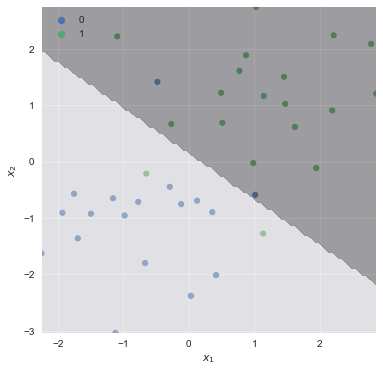

In [36]:
lsc.fit(x_train, y_train_trans, reg_rate=0)
print("Weight vector:\n", lsc.w)
visualize_model(x_train, y_train, lsc)

To visualize the hyperplane (or decision boundary) separating the points:

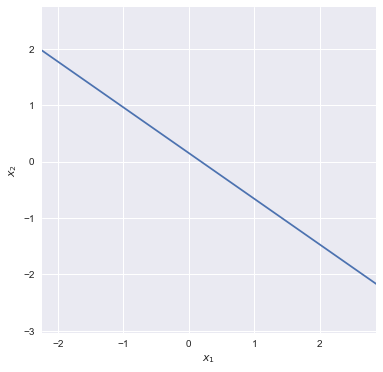

In [44]:
##@title Visualizing the decision boundary

# min,max of feature 1
x1_min = np.min(x_train[:,1])
x1_max = np.max(x_train[:,1])
# min,max of feature 2
x2_min = np.min(x_train[:,2])
x2_max = np.max(x_train[:,2])

plt.figure(figsize=(6,6))

w = lsc.w

x_arr = np.linspace(x1_min, x1_max, 100)
y_arr = 1/(w[2,0]-w[2,1]) * ((w[1,1] - w[1,0])*x_arr + w[0,1]-w[0,0])
# Refer to the explanation below to know why this is the equation of hyperplane

plt.plot(x_arr,y_arr)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.xlim(x1_min,x1_max)
plt.ylim(x2_min,x2_max)
plt.show()

### Explanation for this plot

Firstly, we can only visualize the separating hyperplane, because we only have $2$ features here.

Now, we have the following model:

The label matrix is obtained by matrix multiplication of feature matrix and weight matrix. After adding a dummy feature to the feature matrix, its shape becomes $(n,(m+1))$. It follows the following equation:
$$Y_{n \times k} = X_{n \times (m+1)} W_{(m+1) \times k}$$

So, basically in linear regression for a single label, where we used to get a single weight vector (of $(m+1)$ dimensions) as output, here instead, like in the multi-label linear regression, we actually obtain $k$ weight vectors of $(m+1)$ dimensions each. 

The difference this time lies in the output. In multi-label linear regression, the $k$ labeled output that we get for each example is the required output. But here, we still need to extract a single label (to determine class) from these $k$ labels for a single example.

In order to do that we employ the `argmax` strategy, basically returning the index of the highest label amongst the $k$ labels. This manages to create hyperplanes which separates the $m$ dimensional points into their relevant classes. Let's visualise this using the above $2$ dimensional example.

So, lets say we obtain the weight matrix $W$, using the normal equation method.

In the above example -
`W = 
 [[ 0.52765491  0.47234509]
 [-0.14953508  0.14953508]
 [-0.18434585  0.18434585]]`

if `W = [w0, w1]`

where `w0 = W[:,0]` and `w1 = W[:,1]` are $(m+1)$ dimensional vectors.

Now, consider input: `X = [x1, x2]`
After preprocessing: `X' = [1, x1, x2]`
We get output matrix: `Y' = [y0, y1]`
where `Y' = X' @ W`

Now, as decided above -

`
if y0 > y1:
    output label = 0
else:
    output label = 1
`

So, we get the separating hyperplane `H` which has the following equation:

`
if H>0:
    output label = 0
else:
    output label = 1
`

So, equation of `H = 0` is just `y0 = y1` which translates to ---

`y0 = X'@w0` and `y1 = X'@w1` => `X'@w0 = X'@w1` => `X'@(w0-w1) = 0`.

Since, we are dealing with bunary classification, only one hyperplane is enough to classify. In general for $k$-labelled classification we would require many hyperplanes (in general $\binom{k}{2}$), and we would obtain those many equations (each hyperplane corresponding to a pair of indices would tell us which index is more likely, and after $\binom{k}{2}$ many comparisons, we can conclude which label is most likely with most weights, which is basically what argmax gives us).

To plot learning curves:

In [77]:
def plot_learning_curve(err_all):
    plt.figure(figsize=(8,10))

    err0 = [err[0][0] for err in err_all]
    plt.subplot(2,1,1)
    plt.plot(np.arange(len(err0)), err0, 'r-')
    plt.xlabel("Iter #")
    plt.ylabel("$J(w)[0][0]$")
    plt.title("Loss w.r.t. the first label")

    err1 = [err[1][1] for err in err_all]
    plt.subplot(2,1,2)
    plt.plot(np.arange(len(err1)), err1, 'r-')
    plt.xlabel("Iter #")
    plt.ylabel("$J(w)[1][1]$")
    plt.title("Loss w.r.t. the second label")

    plt.show()

### SGD

Let's train the model with SGD and examine the learning curve.

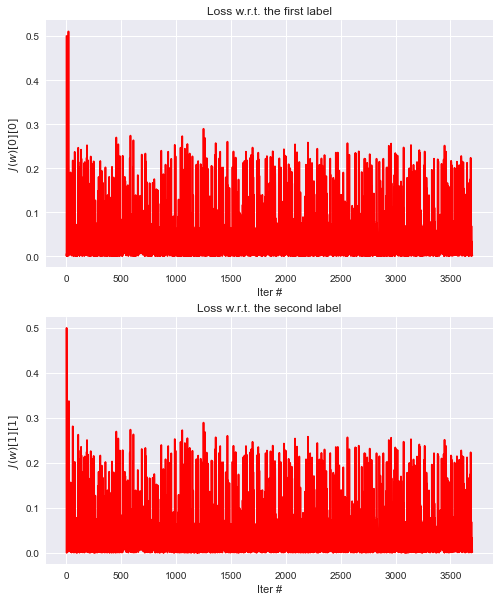

In [78]:
lsc.sgd(x_train, y_train_trans, num_epochs=100, reg_rate=0)
plot_learning_curve(lsc.err_all)

Let's visualize the decision boundary:

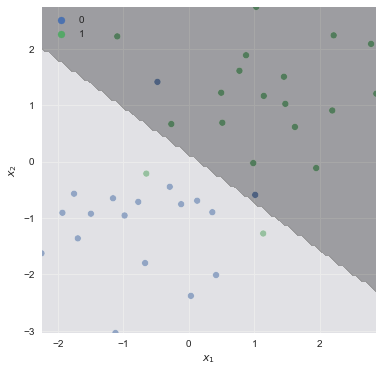

In [79]:
visualize_model(x_train, y_train, lsc)

### GD

In [80]:
lsc.gd(x_train, y_train_trans, num_epochs=100, reg_rate=0, lr=1e-3)

array([[ 0.51186334,  0.45882746],
       [-0.14133014,  0.15729416],
       [-0.18999718,  0.17881844]])

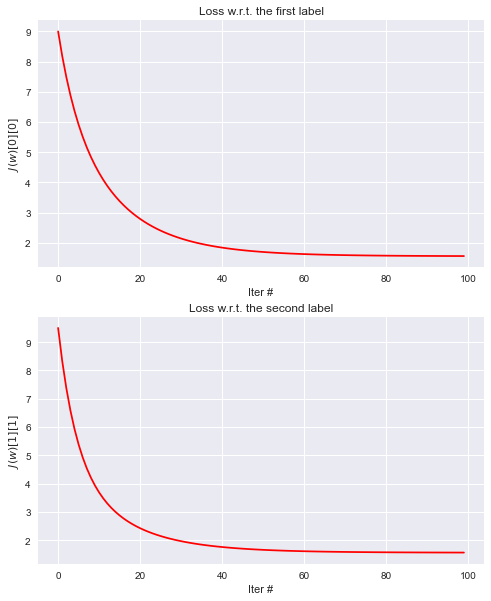

In [81]:
plot_learning_curve(lsc.err_all)

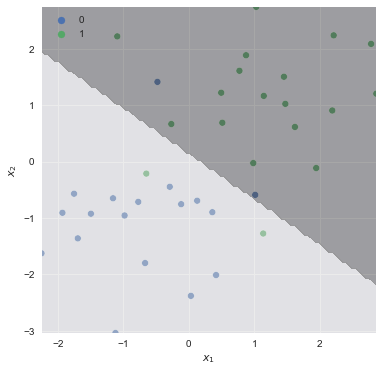

In [82]:
visualize_model(x_train, y_train, lsc)

**NOTE :** We can repeat this evercise by implementing other iterative optimization schemes. This would include Mini Batch Gradient Descent and Stochastic Gradient Descent, and with correct hyperparameter, we can expect similar results.

### Evaluation Metrics

We will use the test set, and evaluate the weights fit that we obtained via GD (gradient descent).

In [83]:
print(x_test.shape)
y_test_pred = lsc.predict(x_test)

(13, 3)


Fet the counts of true positive and negatives and false positives and negatives.

In [88]:
# True positive - True label +, Predicted label +
tp = np.where((y_test == 1) & (y_test_pred == 1), 1, 0).sum()
# True negative - True label -, Predicted label -
tn = np.where((y_test == 0) & (y_test_pred == 0), 1, 0).sum()
# False positive - True label -, Predicted label +
fp = np.where((y_test == 0) & (y_test_pred == 1), 1, 0).sum()
# False negative - True label +, Predicted label -
fn = np.where((y_test == 1) & (y_test_pred == 0), 1, 0).sum()

In [89]:
# precision = Correct positive prediction / Total positive prediction
def precision(tp, fp):
    if (tp+fp) == 0: return np.nan
    return tp/(tp+fp)

In [90]:
# recall = Correct positive prediction / Total positive labels
def recall(tp, fn):
    if (tp+fn) == 0: return np.nan
    return tp/(tp + fn)

In [91]:
# accuracy = Correct predictions / Total labels
def accuracy(tp, fp, tn, fn):
    return (tp+tn)/(tp+tn+fp+fn)

In [92]:
# Harmonic mean of precision and recall
def f1_score(pr, r):
    return 2 * ((pr*r)/(pr+r))

### Classification metrics

In [93]:
pr = precision(tp, fp)
r = recall(tp, fn)
print("Precision: ", pr)
print("Recall: ", r)
print("Accuracy: ", accuracy(tp, fp, tn, fn))
print("F1 Score: ", f1_score(pr, r))

Precision:  0.75
Recall:  1.0
Accuracy:  0.8461538461538461
F1 Score:  0.8571428571428571


## Demo 2: Linearly separable binary classification with outliers

Here, we will demonstrate that the least square classifier (LCS) is highky sensitive to outliers, aka few outliers will drastically change the decision boundary.

In [94]:
x_train, x_test, y_train, y_test, y_train_trans, y_test_trans = preprocess(add_outliers=True)

We add $5$ outliers to one class and check what happens to the decision boundary.

In [95]:
print("Shape of training feature matrix", x_train.shape)
print("Shape of training label vector", y_train.shape)

print("Shape of test feature matrix", x_test.shape)
print("Shape of test label vector", y_test.shape)

Shape of training feature matrix (41, 3)
Shape of training label vector (41,)
Shape of test feature matrix (14, 3)
Shape of test label vector (14,)


Let's visualize the training set:

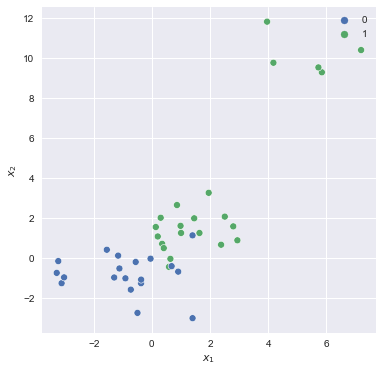

In [96]:
plt.figure(figsize=(6,6))
sns.scatterplot(data=x_train, x=x_train[:,-2], y=x_train[:,-1], hue=y_train)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

The next step is to learn the LSC model on this data and check if it is affected due to the presence of outliers.

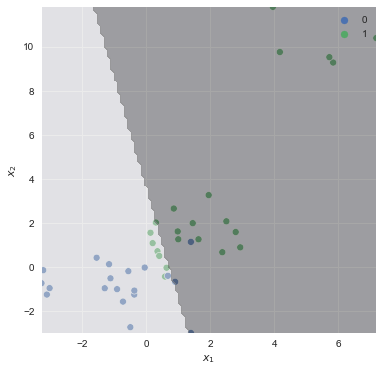

In [97]:
lsc_outlier = LeastSquareClassification()
lsc_outlier.fit(x_train, y_train_trans, reg_rate=0)
visualize_model(x_train, y_train, lsc_outlier)

As we can see the decision boundaries have changed drastically from the non-outliers case, which shows that LSC is highly sensitive to the presence of outliers.

We will get a similar decision boundary, even with the iterative optimization methods.

### Demo 3: Multi-Class set up

In this set up, we will demonstrate multi-class set up with $3$ classes and $2$ features (to visualize the separation).

In [116]:
x_train, x_test, y_train, y_test, y_train_trans, y_test_trans = preprocess(add_class=True)

Let's visualize the training set:

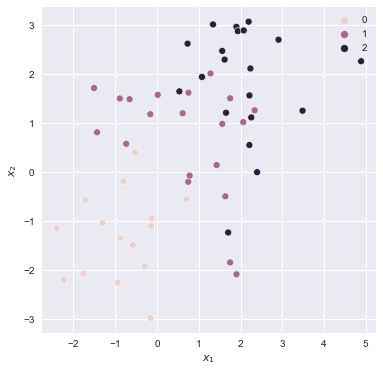

In [117]:
plt.figure(figsize=(6,6))
sns.scatterplot(data=x_train, x=x_train[:,-2], y=x_train[:,-1], hue=y_train)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

Let's perform a sanity check to see if we indeed have $3$ classes:

In [118]:
np.unique(y_train)

array([0, 1, 2])

Now, we train the LCS classifier and visualize the decision boundary.

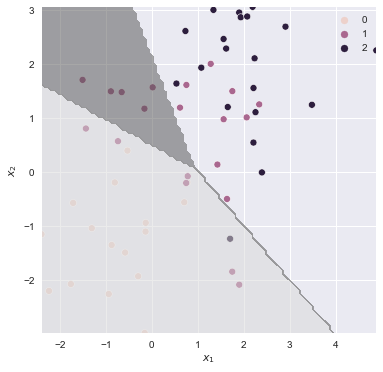

In [119]:
lsc_multi_class = LeastSquareClassification()
lsc_multi_class.fit(x_train, y_train_trans, reg_rate=0)
visualize_model(x_train, y_train, lsc_multi_class)

In [120]:
lsc_multi_class.w

array([[ 0.44839119,  0.36188928,  0.18971953],
       [-0.1119001 , -0.03029575,  0.14219586],
       [-0.14210809,  0.03211811,  0.10998999]])

We can use `classification_report` methods from `sklearn.metrics` module to obtain evaluation metrics for multi-class classifcation in **one vs all** fashion. This can be implemented from scratch by first calculatinf multi-class confusion matrix followed by metric computations.

In [121]:
from sklearn.metrics import classification_report

y_test_pred = lsc_multi_class.predict(x_test)
print(classification_report(y_test, y_test_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89         9
           1       0.00      0.00      0.00         5
           2       0.56      1.00      0.71         5

    accuracy                           0.68        19
   macro avg       0.48      0.63      0.53        19
weighted avg       0.57      0.68      0.61        19



## Demo 4: Polynomial LCS

In this demonstration, we will generate points from two classes such that the decision boundary between them is circular. We will make use of `sklearn.datasets` module to generate the synthetic examples. Specifically, we will use `make_circles` method.

In [123]:
from sklearn.datasets import make_circles
x,y = make_circles()

We will first transform the feature set to obtain polynoial features of degree $2$ and then train least square classifcation on theh transformed feature set.

> Note: We will generally not know with degree to try out for best possible results. So, we will have to use use various learning curves to actually tune the `degree`. But in this case we know for sure that `degree = 2` will suffice, because the decision boundary is circular in nature.

In [124]:
x_poly = polynomial_transform(x, degree=2)

In [125]:
print("Shape of feature matrix before transformation: ", x.shape)
print("Shape of feature matrix after polynomial transformation of degree 2: ", x_poly.shape)

Shape of feature matrix before transformation:  (100, 2)
Shape of feature matrix after polynomial transformation of degree 2:  (100, 6)


In [126]:
x[:5]

array([[ 0.74382119,  0.29449964],
       [-0.2472136 ,  0.76084521],
       [ 0.79369176,  0.10026659],
       [ 0.50993919, -0.61641059],
       [ 0.42577929,  0.90482705]])

In [127]:
x_poly[:5]

array([[ 1.        ,  0.74382119,  0.29449964,  0.55326996,  0.21905507,
         0.08673004],
       [ 1.        , -0.2472136 ,  0.76084521,  0.06111456, -0.18809128,
         0.57888544],
       [ 1.        ,  0.79369176,  0.10026659,  0.62994661,  0.07958076,
         0.01005339],
       [ 1.        ,  0.50993919, -0.61641059,  0.26003798, -0.31433192,
         0.37996202],
       [ 1.        ,  0.42577929,  0.90482705,  0.18128801,  0.38525662,
         0.81871199]])

In [128]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_poly, y)

Let's encode the labels with `LabelTransformer`

In [129]:
y_train_trans = LabelTransformer(2).encode(y_train)
y_test_trans = LabelTransformer(2).encode(y_test)

In [130]:
print(y_train_trans.shape, y_test_trans.shape)

(75, 2) (25, 2)


Let's visualize the training data:

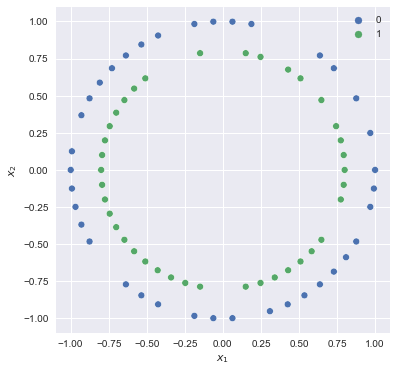

In [131]:
plt.figure(figsize=(6,6))
sns.scatterplot(data=x_train, x=x_train[:,1], y=x_train[:,2], hue=y_train)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

Let's build the least square classification model and visualize the decision boundary.

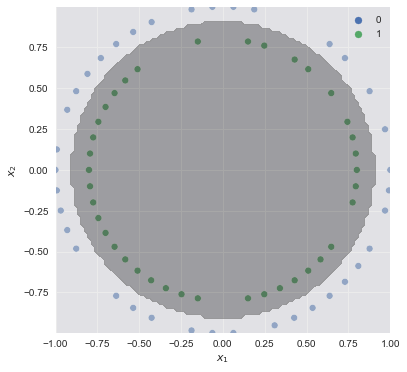

In [132]:
lsc_poly = LeastSquareClassification()
lsc_poly.fit(x_train, y_train_trans, reg_rate=0)
visualize_model(x_train, y_train, lsc_poly, degree=2)

In [133]:
from sklearn.metrics import classification_report

y_test_pred = lsc_poly.predict(x_test)
print(classification_report(y_test, y_test_pred, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        12

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25



# Summary

- We implemented Least Square Classifier (LSC) from scratch.
- We also implemented **label encoder** to transform the output labels into usable form (for both binary and multi-class) classification setup.
- We have looked at four types of problems:
    - first with binary linearly separable data without outliers
    - second with binary separable data with outliers
    - third with multiclass separable data (in our case we looked at separating into three classes)
    - fourth with non linearly separable data
- The first three problems (binary and multiclass) could be addressed with basic LSC, while the fourth required additional step of **polynomial transformation** before employing LSC.
- We concluded from the second case that LSC is highly sensitive to the presence of outliers.
- We also analyzed how the decision boundaries work, and visualized the same.
